# Rede Neural Feedforward

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

E:\Anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data

Nesta aula, vamos usar a coleção MNIST. 

In [3]:
mnist = input_data.read_data_sets('data/MNIST_data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST_data\train-labels-idx1-ubyte.gz
Extracting data/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
print(mnist.train.num_examples)
print(mnist.test.num_examples)

55000
10000


Esta é uma coleção com 55 mil casos de treino e 10 mil casos de teste. Cada instância é a imagem de 28x28 pixels de um número de 0 a 9 (em escala de cinza). Nosso objetivo é reconhecer o número. O atual estado-da-arte para este problema tem acurácia de 99.79 (Novembro de 2016, http://paper.researchbib.com/view/paper/104069). 

1


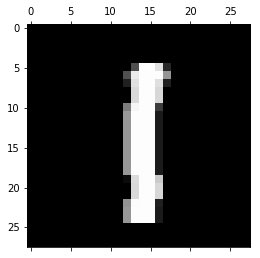

In [5]:
import random
idx = random.randint(0, mnist.train.num_examples)
plt.matshow(mnist.train.images[idx].reshape((28,28)), cmap = 'gray')
print(mnist.train.labels[idx])

In [6]:
class Activation(object):
    """Funcao de ativacao"""
    def __init__(self, name):
        self.name = name
        
    def init(self, n_inputs, n_outputs):
        return tf.random_uniform([n_inputs, n_outputs], -1.0, 1.0)
        
    def fire(self, ypred):
        if self.name == 'sigmoid':
            return tf.nn.sigmoid(ypred) 
        else:
            return ypred
            
class Layer(object):
    """Camada de rede neural sequencial"""
    def __init__(self, units, activation = None, name = None):
        self.units = units
        self.name = name 
        self.activation = activation if activation != None else Activation('')
        
    def output(self, X):
        n_inputs = int(X.get_shape()[1])
        with tf.name_scope(self.name):
            self.W = tf.Variable(self.activation.init(n_inputs, self.units), name = 'W')
            self.b = tf.Variable(tf.zeros([self.units]), name = 'b')
            ypred = self.activation.fire(tf.matmul(X, self.W) + self.b)
        return ypred

class LossFunction(object):
    def __init__(self, name = 'sigmoid'):
        self.name = name

    def get(self, yreal, ypred):
        if self.name == 'sigmoid':
            loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels = yreal, logits = ypred) 
        return tf.reduce_mean(loss, name = 'lossf')
    
class Optimizer(object):
    def __init__(self, name = 'sgd'):
        self.name = name
        self.lrate = 0.1

    def get(self, lossf):
        if self.name == 'sgd':
            opt = tf.train.GradientDescentOptimizer(learning_rate = self.lrate) 
        return opt.minimize(lossf)
    
class FeedforwardNeuralNet(object):
    """Rede neural sequencial"""
    def __init__(self, input_dim):
        self.input_dim = input_dim
        self.learning_rate = 0.1
        self.layers = []
        
    def add(self, units, activation = None, name = None):
        """Adiciona camadas para rede neural"""
        self.layers += [Layer(units, activation, name)]
    
    def compile(self, loss = 'sigmoid', optimizer = 'sgd'):
        """Cria grafo da rede neural"""
        self.X = tf.placeholder(tf.float32, 
                           shape = (None, self.input_dim), 
                           name = 'X')
        self.y = tf.placeholder(tf.int64, shape = (None), name = 'y')
        
        # cria layers
        with tf.name_scope('layers'):
            layer_in = self.X
            for layer in self.layers:
                layer_out = layer.output(layer_in)
                layer_in = layer_out
                    
        # loss function
        with tf.name_scope('loss'):
            self.lossf = LossFunction(loss).get(self.y, layer_out)
    
        # optimizer
        with tf.name_scope('train'):
            self.train_op = Optimizer(optimizer).get(self.lossf)
            
        # evalution metrics
        with tf.name_scope('eval'):
            correct = tf.nn.in_top_k(layer_out, self.y, 1)
            self.acc = tf.reduce_mean(tf.cast(correct, tf.float32))
            
        self.init_op = tf.global_variables_initializer()
        self.saver = tf.train.Saver()
    
    def fit(self, train_data, n_epochs, batch_size):
        """Executa treino da rede neural"""
        num_batches = train_data.num_examples // batch_size
        with tf.Session() as s:
            s.run(self.init_op)
            for e in range(n_epochs):
                tloss = 0.
                for i in range(num_batches):
                    X_b, y_b = train_data.next_batch(batch_size)
                    _, loss_e = s.run([self.train_op, self.lossf], 
                                      feed_dict = {self.X: X_b, self.y: y_b})
                    tloss += loss_e
                acc_train = s.run(self.acc, 
                                  feed_dict = {self.X: X_b, self.y: y_b})
                print('%2d loss: %.8f acc: %.2f' % (e, tloss/num_batches, acc_train))
            self.saver.save(s, '/tmp/model.ckpt') 
    
    def evaluate(self, X_test, y_test):
        """Avalia rede neural em colecao de teste"""
        with tf.Session() as s:
            self.saver.restore(s, '/tmp/model.ckpt')
            acc_test = s.run(self.acc, 
                             feed_dict = {self.X: X_test, self.y: y_test})
        return acc_test

### Usando nossa rede neural

In [7]:
tf.reset_default_graph()

model = FeedforwardNeuralNet(input_dim = 28*28)

model.add(units=300, activation = Activation('sigmoid'), name = 'h1')
model.add(units=100, activation = Activation('sigmoid'), name = 'h2')
model.add(units=10, name = 'out')

model.compile()

In [8]:
model.fit(mnist.train, n_epochs = 10, batch_size = 50)

 0 loss: 0.76269900 acc: 0.86
 1 loss: 0.37637324 acc: 0.94
 2 loss: 0.30266735 acc: 0.90
 3 loss: 0.26168132 acc: 0.96
 4 loss: 0.23361137 acc: 0.98
 5 loss: 0.21224959 acc: 0.98
 6 loss: 0.19536860 acc: 0.90
 7 loss: 0.18075725 acc: 0.94
 8 loss: 0.16841592 acc: 0.96
 9 loss: 0.15768284 acc: 0.92


In [9]:
model.evaluate(mnist.test.images, mnist.test.labels)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


0.9416

## Hiper parâmetros

* Número de camadas: dependendo da complexidade do problema, mais é melhor. Em geral, se ganha mais com mais camadas que com mais neurônios. Além disso, elas permitem a transferência de aprendizado, já que você não precisa treinar a rede toda. Pode sempre aproveitar camadas anteriores pré-treinadas. Uma estratégia comum é usar muitas camadas e checar _overfitting_. Se ele ocorre, começamos a fazer regularização.

* _Número de neurônios por camada_: quanto mais melhor. Contudo, dado a natureza hierárquica do aprendizado, é comum uma estrutura geral de funil, pois é mais provável que usemos mais atributos de baixo nível que de alto nível. Uma estratégia comum é usar muitos neurônios e verificar _overfitting_. Se ele ocorre, então regularizamos para diminui-lo. 

* _Funções de ativação_: vamos usar quase sempre ReLU e suas variantes. Em classificação, a última camada é normalmente _softmax_. Em regressão, nenhuma ativação é usada na última camada. 

## Treinando FNNs profundas

### Vanishing and Exploding Gradients

Métodos dependem de gradientes. Contudo, gradientes podem desaparecer ou explodir, inviabilizando o aprendizado. Uma das razões para saturação são o uso combinado de funções de ativação que saturam (como sigmoids e variantes) e métodos de normalização de média 0, variância 1. 

O efeito dessa combinação é que a variância da saída de cada camada é bem mais alta que da entrada. Logo, após várias camadas, esta variância leva a ocorrência de valores críticos.

Uma solução para este problema é o uso de diferentes funções de ativação (ReLU e família) e diferentes técnicas de inicialização (Xavier e He).

#### Inicialização de Xavier (ou Glorot)

Variância da saída deveria ser igual da entrada; o mesmo vale para variância dos gradientes antes e depois de passar por uma camada na volta. Embora não seja possível garantir isso, um bom compromisso é alcançado se os pesos forem inicializados assim:

* normalização média 0, variância $\sigma$: $\sigma = \alpha \sqrt{\frac{2}{n_{entradas}+n_{saidas}}}$
* normalização uniforme entre $-r$ e $+r$: $r = \alpha \sqrt{\frac{6}{n_{entradas}+n_{saidas}}}$

Onde $\alpha$ é 1 para ativação sigmoid, 4 para tangente hiperbólica e $\sqrt{2}$ para ReLU. Quando o número de entradas e saídas é basicamente o mesmo, vc pode usar:

* normalização média 0, variância $\sigma$: $\sigma = \alpha \frac{1}{\sqrt{n_{entradas}}}$
* normalização uniforme entre $-r$ e $+r$: $r = \alpha \frac{\sqrt{3}}{\sqrt{n_{entradas}}}$

In [8]:
class Activation(object):
    """Funcao de ativacao"""
    def __init__(self, name):
        self.name = name
                
    def init(self, n_inputs, n_outputs):
        """Xavier initialization"""
        if self.name == 'sigmoid':
            stddev = np.sqrt(2. / (n_inputs + n_outputs))
        else:
            stddev = 2. / np.sqrt(n_inputs + n_outputs)
        return tf.truncated_normal((n_inputs, n_outputs), stddev = stddev)
        
    def fire(self, ypred):
        if self.name == 'sigmoid':
            return tf.nn.sigmoid(ypred) 
        elif self.name == 'relu':
            return tf.nn.relu(ypred)
        else:
            return ypred

In [9]:
tf.reset_default_graph()

model = FeedforwardNeuralNet(input_dim = 28*28)

model.add(units=300, activation = Activation('sigmoid'), name = 'h1')
model.add(units=100, activation = Activation('sigmoid'), name = 'h2')
model.add(units=10, name = 'out')

model.compile()

In [12]:
model.fit(mnist.train, n_epochs = 10, batch_size = 50)

 0 loss: 1.05048586 acc: 0.80
 1 loss: 0.39163126 acc: 0.84
 2 loss: 0.32634528 acc: 0.96
 3 loss: 0.29699917 acc: 0.90
 4 loss: 0.27530011 acc: 0.90
 5 loss: 0.25641846 acc: 0.88
 6 loss: 0.24033329 acc: 0.96
 7 loss: 0.22454761 acc: 0.92
 8 loss: 0.21074877 acc: 0.96
 9 loss: 0.19779807 acc: 0.98


In [13]:
model.evaluate(mnist.test.images, mnist.test.labels)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


0.9441

### Função de ativação não saturáveis

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

[-5, 5, -0.2, 1.2]

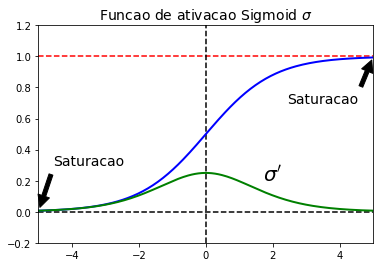

In [12]:
z = np.linspace(-5, 5, 200)
sz = sigmoid(z)
dsz = np.gradient(sz, z)

plt.plot([-5, 5], [0, 0], 'k--')
plt.plot([-5, 5], [1, 1], 'r--')
plt.plot([0, 0], [-0.2, 1.2], 'k--')
plt.plot(z, sz, "b-", linewidth=2)
plt.plot(z, dsz, "g-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturacao', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturacao', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate(r"$\sigma'$", xytext=(2, 0.2), xy=(0, 0.5), fontsize=20, ha="center")
plt.title(r"Funcao de ativacao Sigmoid $\sigma$", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

O grande problema de sigmoids (incluindo a tangente hiperbólica) é a existência de regiões de saturação. 

Para lidar com este problema, foram introduzidas as Rectifier Linear Units -- ReLUs.

In [13]:
def relu(z):
    return np.maximum(0, z)

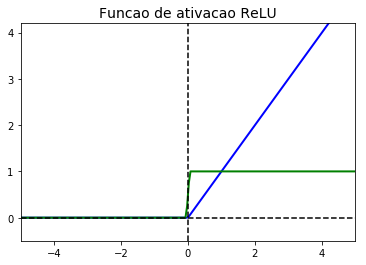

In [14]:
rz = relu(z)
drz = np.gradient(rz, z)

plt.plot(z, rz, "b-", linewidth=2)
plt.plot(z, drz, "g-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k--')
plt.plot([0, 0], [-0.5, 4.2], 'k--')
props = dict(facecolor='black', shrink=0.1)
plt.title("Funcao de ativacao ReLU", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

In [15]:
tf.reset_default_graph()

model = FeedforwardNeuralNet(input_dim = 28*28)

model.add(units=300, activation = Activation('relu'), name = 'h1')
model.add(units=100, activation = Activation('relu'), name = 'h2')
model.add(units=10, name = 'out')

model.compile()

In [19]:
model.fit(mnist.train, n_epochs = 10, batch_size = 50)

 0 loss: 0.28673112 acc: 1.00
 1 loss: 0.12325674 acc: 1.00
 2 loss: 0.08538376 acc: 1.00
 3 loss: 0.06277581 acc: 1.00
 4 loss: 0.04825924 acc: 1.00
 5 loss: 0.03707605 acc: 1.00
 6 loss: 0.02926872 acc: 1.00
 7 loss: 0.02138758 acc: 1.00
 8 loss: 0.01664940 acc: 1.00
 9 loss: 0.01198216 acc: 1.00


In [21]:
0.1+0.2-0.3 ==0

False

In [22]:
model.evaluate(mnist.test.images, mnist.test.labels)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


0.9788

Um problema com ReLUs é que elas podem ainda saturar em 0. Assim, novas variantes foram criadas como Leaky ReLU, ELU (Exponential Linear Unit) e SELU (Self-normlizing Exponential Linear Unit).

A ideia da leakyReLU e eLU é que não haja saturação em 0. A leakyReLU usa uma estratégia linear e a eLU, uma estratégia exponencial. Como a eLU sempre é melhor que a leakyReLU, vamos mostrar o seu efeito a seguir.

In [16]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

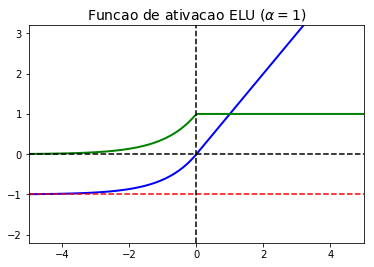

In [17]:
ez = elu(z)
dez = np.gradient(ez, z)

plt.plot(z, ez, "b-", linewidth=2)
plt.plot(z, dez, "g-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k--')
plt.plot([-5, 5], [-1, -1], 'r--')
plt.plot([0, 0], [-2.2, 3.2], 'k--')
plt.title(r"Funcao de ativacao ELU ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

In [18]:
def fire(self, ypred):
    if self.name == 'sigmoid':
        return tf.nn.sigmoid(ypred) 
    elif self.name == 'relu':
        return tf.nn.relu(ypred)
    elif self.name == 'elu':
        return tf.nn.elu(ypred)
    else:
        return ypred
        
Activation.fire = fire

In [19]:
tf.reset_default_graph()

model = FeedforwardNeuralNet(input_dim = 28*28)

model.add(units=300, activation = Activation('elu'), name = 'h1')
model.add(units=100, activation = Activation('elu'), name = 'h2')
model.add(units=10, name = 'out')

model.compile()

In [27]:
model.fit(mnist.train, n_epochs = 10, batch_size = 50)

 0 loss: 0.29459507 acc: 0.96
 1 loss: 0.14510611 acc: 0.96
 2 loss: 0.10564223 acc: 1.00
 3 loss: 0.08409390 acc: 0.98
 4 loss: 0.06919516 acc: 1.00
 5 loss: 0.05796448 acc: 1.00
 6 loss: 0.04923700 acc: 1.00
 7 loss: 0.04204264 acc: 1.00
 8 loss: 0.03683003 acc: 0.98
 9 loss: 0.03107884 acc: 1.00


In [28]:
model.evaluate(mnist.test.images, mnist.test.labels)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


0.9783

Outro problema é que, na prática, mesmo que a entrada seja normalizada em média 0, variância 1, as camadas seguintes vão perdendo essa normalização (esse problema é conhecido como _internal covariate shift_, ver https://github.com/aleju/papers/blob/master/neural-nets/Batch_Normalization.md).

Uma forma de lidar com esse problema é aprender, durante o treino, a média e a variância de cada camada. Assim, é possível re-normalizar a entrada das camadas seguintes. Esses dois novos parâmetros pode ser estimados nos batches, através de uma estratégia que que ficou conhecida como _batch normalization_ -- BN (ver https://github.com/aleju/papers/blob/master/neural-nets/Batch_Normalization.md). O uso de BN virtualmente acaba com os problemas de perda e estouro de gradientes.

Mais recentemente (junho de 2017), uma alternativa à BN, a função SELU, foi proposta em um artigo (https://arxiv.org/pdf/1706.02515.pdf) de Günter Klambauer, Thomas Unterthiner e Andreas Mayr. A ideia é que a própria função de ativação já garanta saídas normalizadas, sem necessidade de parâmetros adicionais. Embora muito recente, esta tem se mostrado a melhor solução para o problema em redes profundas.

In [20]:
# valores de SELU para media 0, desvio 1
# ver paper para detalhes
def selu(z,
         scale = 1.0507009873554804934193349852946,
         alpha = 1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

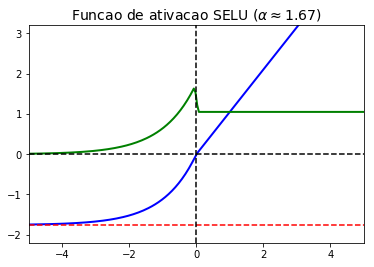

In [21]:
sz = selu(z)
dsz = np.gradient(sz, z)

plt.plot(z, sz, "b-", linewidth=2)
plt.plot(z, dsz, "g-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k--')
plt.plot([-5, 5], [-1.758, -1.758], 'r--')
plt.plot([0, 0], [-2.2, 3.2], 'k--')
plt.title(r"Funcao de ativacao SELU ($\alpha \approx 1.67$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

A SeLU tem a propriedade de preservar a variância em torno de 1 (média 0), para redes com muitas camadas (centenas delas), evitando assim o problema de desaparecimento e explosão de gradientes.

In [22]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(200):
    W = np.random.normal(size=(100, 100), scale = np.sqrt(1./100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 20 == 0:
        print("Layer {}: {:.2f} < media < {:.2f}, {:.2f} < stddev < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

Layer 0: -0.26 < media < 0.27, 0.74 < stddev < 1.27
Layer 20: -0.17 < media < 0.18, 0.74 < stddev < 1.24
Layer 40: -0.38 < media < 0.39, 0.74 < stddev < 1.25
Layer 60: -0.26 < media < 0.43, 0.74 < stddev < 1.35
Layer 80: -0.18 < media < 0.16, 0.72 < stddev < 1.19
Layer 100: -0.26 < media < 0.32, 0.74 < stddev < 1.26
Layer 120: -0.19 < media < 0.20, 0.78 < stddev < 1.36
Layer 140: -0.24 < media < 0.34, 0.74 < stddev < 1.14
Layer 160: -0.27 < media < 0.21, 0.72 < stddev < 1.22
Layer 180: -0.35 < media < 0.35, 0.77 < stddev < 1.41


In [23]:
class Activation(object):
    """Funcao de ativacao"""
    def __init__(self, name):
        self.name = name
                
    def init(self, n_inputs, n_outputs):        
        if self.name == 'selu':
            stddev = np.sqrt(1./n_inputs)
        elif self.name == 'sigmoid':
            stddev = np.sqrt(2. / (n_inputs + n_outputs))
        else:
            stddev = 2. / np.sqrt(n_inputs + n_outputs)
        return tf.truncated_normal((n_inputs, n_outputs), stddev = stddev)
        
    def fire(self, ypred):
        def selu(z, scale=1.0507009873554804934193349852946,
                 alpha=1.6732632423543772848170429916717):
            return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))        
        
        if self.name == 'sigmoid':
            return tf.nn.sigmoid(ypred) 
        elif self.name == 'relu':
            return tf.nn.relu(ypred)
        elif self.name == 'elu':
            return tf.nn.elu(ypred)
        elif self.name == 'selu':
            return selu(ypred)
        else:
            return ypred

In [24]:
class SNN(FeedforwardNeuralNet):
    """Rede neural sequencial auto-normalizavel"""
    def __init__(self, input_dim):
        FeedforwardNeuralNet.__init__(self, input_dim)
        
    def fit(self, train_data, n_epochs, batch_size):
        """Executa treino da rede neural"""
        self.means = train_data.images.mean(axis=0, keepdims=True)
        self.stds = train_data.images.std(axis=0, keepdims=True) + 1e-10

        num_batches = train_data.num_examples // batch_size
        with tf.Session() as s:
            s.run(self.init_op)
            for e in range(n_epochs):
                tloss = 0.
                for i in range(num_batches):
                    X_b, y_b = train_data.next_batch(batch_size)
                    # scale data!
                    X_b_scaled = (X_b - self.means) / self.stds
                    _, loss_e = s.run([self.train_op, self.lossf], 
                                      feed_dict = {self.X: X_b_scaled, self.y: y_b})
                    tloss += loss_e
                acc_train = s.run(self.acc, 
                                  feed_dict = {self.X: X_b_scaled, self.y: y_b})
                print('%2d loss: %.8f acc: %.2f' % (e, tloss/num_batches, acc_train))
            self.saver.save(s, '/tmp/model.ckpt')
            
    
    def evaluate(self, X_test, y_test):
        """Avalia rede neural em colecao de teste"""
        with tf.Session() as s:
            self.saver.restore(s, '/tmp/model.ckpt')
            X_test_scaled = (X_test - self.means) / self.stds
            acc_test = s.run(self.acc, 
                             feed_dict = {self.X: X_test_scaled, self.y: y_test})
        return acc_test

In [25]:
tf.reset_default_graph()

model = SNN(input_dim = 28*28)

model.add(units=300, activation = Activation('selu'), name = 'h1')
model.add(units=100, activation = Activation('selu'), name = 'h2')
model.add(units=10, name = 'out')

model.compile()

In [26]:
model.fit(mnist.train, n_epochs = 10, batch_size = 50)

 0 loss: 0.28533542 acc: 0.98
 1 loss: 0.13552079 acc: 1.00
 2 loss: 0.09023499 acc: 1.00
 3 loss: 0.06528229 acc: 1.00
 4 loss: 0.04601010 acc: 1.00
 5 loss: 0.03279021 acc: 1.00
 6 loss: 0.02714882 acc: 1.00
 7 loss: 0.01862058 acc: 1.00
 8 loss: 0.01313842 acc: 1.00
 9 loss: 0.00903148 acc: 1.00


In [27]:
model.evaluate(mnist.test.images, mnist.test.labels)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


0.9753

Antes da introdução das SELUs, BN era a técnica preferível para lidar com o problema de deriva de co-variância. Atualmente, há uma tendência para preferir a solução com SELUs, pois:

* A propriedade de auto-normalização de SELUs é baseada em um arcabouço matemático sólido;
* Elas são bem mais simples que BN, uma vez que a função de ativação já produz saídas normalizadas;
* Há razoável comprovação empiríca (na medida em que é possível dado o pouco tempo de existência das SELUs) de que elas atingem maior acuidade em menos tempo, quando aplicadas a redes com várias camadas, em comparação a ReLUs, ELUs e BN. 

_Note que BNs ainda podem ser úteis onde SELUs não puderem ser usadas, como qualquer rede em que uma função muito particular de perda tiver que ser usada que não case bem com SELUs (embora este seja o caso de LSTMs, há atualmente um esforço grande em adaptar SELUs para LSTMs). Além disso, BN também opera como regularizador, o que pode resultar em melhores desempenhos em arquiteturas como as CNNs. A seguir, temos uma explicação um pouco melhor sobre BNs. Vamos ver exemplos de uso mais à frente, com Keras._

#### Batch normalization

Este método foi descrito por [Ioffe and Szegedy](https://arxiv.org/abs/1502.03167) para acelerar o treinamento de redes neurais. Ele é baseada num simples modo de falha que atrapalha o treinamento de redes neurais: _à medida que o sinal se propaga pela rede, mesmo se normalizado na entrada, ele pode acabar completamente enviesado em alguma camada oculta, tanto em termos de variância quanto média_ (efeito conhecido como *deriva interna da covariância*). Isto resulta em grandes discrepâncias entre as atualizações de gradientes ao longo de diferentes camadas. Como resultado, somos mais conservadores com a taxa de aprendizado e aplicamos regularizadores mais fortes, o que desacelera o treino.

Batch normalization propõe a normalização das ativações de uma camada para média zero e variância 1, através do batch de dados passando pela rede (ou seja, no treino, nós normalizamos pelos `batch_size` exemplos e, no teste, normalizamos considerando estatísticas derivadas do _treino todo_---uma vez que não conhecemos os dados de teste com antecedência). Nós calculamos a média e a variância para um batch particular de ativações $\mathcal{B} = \{x_1, \dots, x_m\}$ assim:

$$\begin{align*}\mu_{\mathcal{B}} &= \frac{1}{m}\sum_{i=1}^{m}x_i \\ \sigma_\mathcal{B}^2 &= \frac{1}{m}\sum_{i=1}^{m}\left(x_i - \mu_\mathcal{B}\right)^2\end{align*}$$

Nós então usamos estas estatísticas para transformar as ativações de forma que elas tenham média zero e variância um:

$$\hat{x}_i = \frac{x_i - \mu_\mathcal{B}}{\sqrt{\sigma_\mathcal{B}^2 + \varepsilon}}$$

onde $\varepsilon > 0$ é um pequeno valor que nos protege de divisão por zero (no caso do desvio padrão do batch ser muito pequeno ou mesmo zero). Finalmente, para obter a ativação final $y$, precisamos estar certos que nenhuma propriedade de generalizaçao foi perdida ao executar a normalização---e desde que as operações feitas foram um deslocamento (média) e um escalonamento (desvio), nós permitimos um deslocamento e um escalonamento arbitrários dos valores normalizados para obter o valor final (isso permite a rede, por exemplo, voltar aos valores originais se ela os considerar mais úteis):

$$y_i = \gamma\hat{x}_i + \beta$$

onde $\beta$ e $\gamma$ são parâmetros *treináveis* da operação de batch normalization (otimizáveis via gradiente descendente nos dados de treino). Esta generalização significa que batch normalisation pode se aplicada diretamente às _entradas_ da rede neural (dado que a presença desses parâmetros permite à rede assumir uma estatística de entrada diferente da que nós selecionamos através do processamento manual dos dados).

Este método, quando aplicado às camadas de uma rede convolutiva quase sempre levam a maior velocidade do aprendizado. Eles também agem como ótimos regularizadores, nos permitindo um cuidado maior na escolha da taxa de aprendizado, na importância do $L_2$ e uso do dropout (tornando-o muitas vezes completamente desnecessário). Esta regularização ocorre como consequência do fato de que a saída de um único exemplo *não é mais determinística* (já que ela depende do batch inteiro a qual ela pertence), ajudando a rede a generalizar melhor.

Note que no artigo original, os autores usam batch normalization *antes* de aplicar a função de ativação do neurônio (nas combinações lineares computadas dos dados de entrada). Contudo, [em resultados recentes](http://arxiv.org/abs/1511.06422) observou-se que poderia ser mais benéfico (e, no mínimo, tao bom quanto) aplicá-la *depois*.

Em Keras, batch normalisation corresponde a uma camada: `BatchNormalization`, para a qual podemos fornecer alguns parâmetros. O mais importante deles é o `axis` (sobre que eixo dos dados as estatísticas deveriam ser computadas). Em particular, quando trabalhando com camadas de convolução, queremos normalizar através dos canais individuais, logo `axis = 1`.

### Otimizadores

Os otimizadores a serem usados com redes neurais são os mesmos que vimos antes, uma vez que o gradiente descendente é um caso particular da propagação retrógrada. 

Dos vários métodos que vimos antes, a opção em geral será pelo Adam, que combina momento com taxas de aprendizado pora cada dimensão (adaptativo). Eventualmente, quando se quiser um modelo muito esparso (e rápido no teste), deve-se optar pelo FTRLOpimizer (junto com uma regularização $L_1$ -- a ser visto mais tarde).

In [30]:
class Optimizer(object):
    def __init__(self, name = 'sgd'):
        self.name = name
        self.lrate = 0.1

    def get(self, lossf):
        if self.name == 'sgd':
            opt = tf.train.GradientDescentOptimizer(learning_rate = self.lrate) 
        elif self.name == 'adam':
            opt = tf.train.AdamOptimizer() 
        return opt.minimize(lossf)

In [31]:
tf.reset_default_graph()

model = FeedforwardNeuralNet(input_dim = 28*28)

model.add(units=300, activation = Activation('relu'), name = 'h1')
model.add(units=100, activation = Activation('relu'), name = 'h2')
model.add(units=10, name = 'out')

model.compile(optimizer = 'adam')

In [32]:
model.fit(mnist.train, n_epochs = 10, batch_size = 50)

 0 loss: 0.22149987 acc: 0.96
 1 loss: 0.09076463 acc: 0.96
 2 loss: 0.05697486 acc: 1.00
 3 loss: 0.04194708 acc: 0.98
 4 loss: 0.03391871 acc: 1.00
 5 loss: 0.02644770 acc: 1.00
 6 loss: 0.02029505 acc: 1.00
 7 loss: 0.02090722 acc: 1.00
 8 loss: 0.01641303 acc: 1.00
 9 loss: 0.01407519 acc: 1.00


In [33]:
model.evaluate(mnist.test.images, mnist.test.labels)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


0.9764

#### Gradient clipping

Antes de BNs e SNNs, era comum o uso de corte de gradientes para evitar estouro de gradientes. Atualmente, esquemas de normalização são preferidos. Contudo, é importante entender esta técnica, especialmente para o caso onde a normalização não puder ser trivialmente aplicada, como LSTMs.

A ideia de clipping é cortar todos os gradientes que estão abaixo ou acima de valores críticos, de forma que eles assumam os valores críticos.

In [34]:
class Optimizer(object):
    def __init__(self, name = 'sgd'):
        self.name = name
        self.lrate = 0.1
        self.threshold = 1

    def get(self, lossf):
        if self.name == 'sgd':
            opt = tf.train.GradientDescentOptimizer(learning_rate = self.lrate) 
            return opt.minimize(lossf)
        
        elif self.name == 'clipped_sgd':
            opt = tf.train.GradientDescentOptimizer(learning_rate = self.lrate) 
            grads_vars = opt.compute_gradients(lossf)
            clipped_vals = [(tf.clip_by_value(grad, -self.threshold, self.threshold), var) 
                            for grad, var in grads_vars]
            return opt.apply_gradients(clipped_vals)
        
        elif self.name == 'adam':
            opt = tf.train.AdamOptimizer() 
            return opt.minimize(lossf)

In [35]:
tf.reset_default_graph()

model = FeedforwardNeuralNet(input_dim = 28*28)

model.add(units=300, activation = Activation('relu'), name = 'h1')
model.add(units=100, activation = Activation('relu'), name = 'h2')
model.add(units=10, name = 'out')

model.compile(optimizer = 'clipped_sgd')

In [36]:
model.fit(mnist.train, n_epochs = 10, batch_size = 50)

 0 loss: 0.27929616 acc: 1.00
 1 loss: 0.12198854 acc: 1.00
 2 loss: 0.08302177 acc: 1.00
 3 loss: 0.06140562 acc: 1.00
 4 loss: 0.04680037 acc: 1.00
 5 loss: 0.03567845 acc: 1.00
 6 loss: 0.02822019 acc: 1.00
 7 loss: 0.02090556 acc: 1.00
 8 loss: 0.01595843 acc: 1.00
 9 loss: 0.01254436 acc: 1.00


In [38]:
model.evaluate(mnist.test.images, mnist.test.labels)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


0.9781

#### Política de evolução de taxa de aprendizado (_learning rate schedulling_)

A ideia aqui é modificar a taxa de aprendizado de acordo com uma política de evolução em lugar de usar uma taxa fixa. Naturalmente, esta é uma possibilidade apenas para os métodos não adaptativos, uma vez que estes modificam a taxa de aprendizado de acordo com o processo de otimização.

Para os métodos em que tais políticas fazem sentido, as principais estratégias são:

* _Modificação em intervalos pre-determinados_: por exemplo, inicie com 0.1 e, então, após 50 épocas, mude para 0.001. Complicado aqui é definir que valores usar e quando mudar.

* _Modificação de acordo com desempenho_: a cada N passos, avalie o erro no conjunto de validação e, se este parou de cair, reduza a taxa por um fator $\lambda$.

* _Escala exponencial_: diminua a taxa de aprendizado por um fator de 10 a cada $r$ passos. Assm, dado o passo $t$, um valor inicial $\eta_0$, $\eta(t) = \eta_0 10^{\frac{-t}{r}}$

* _Escala de potência_: equivalente ao anterior, mas bem mais lento. Nesse caso, $\eta(t) = \eta_0 (1 + \frac{t}{r})^{-c}$, onde $c$ é tipicamente definido como 1.

In [39]:
class Optimizer(object):
    def __init__(self, name = 'sgd'):
        self.name = name
        self.lrate = 0.1
        # clipping
        self.threshold = 1
        # scheduling
        self.initial_lrate = 0.1 # eta0
        self.decay_steps = 10000 # r
        self.decay_rate = 1./10 
        self.global_step = tf.Variable(0, trainable = False) ##

    def get(self, lossf):
        if self.name == 'sgd':
            opt = tf.train.GradientDescentOptimizer(learning_rate = self.lrate) 
            return opt.minimize(lossf)
        
        elif self.name == 'clipped_sgd':
            opt = tf.train.GradientDescentOptimizer(learning_rate = self.lrate) 
            grads_vars = opt.compute_gradients(lossf)
            clipped_vals = [(tf.clip_by_value(grad, -self.threshold, self.threshold), var) 
                            for grad, var in grads_vars]
            return opt.apply_gradients(clipped_vals)
        
        elif self.name == 'exp_decay_momentum':
            lrate = tf.train.exponential_decay(self.initial_lrate,
                                              self.global_step,
                                              self.decay_steps,
                                              self.decay_rate)
            opt = tf.train.MomentumOptimizer(learning_rate = lrate, momentum = 0.9)  ##
            return opt.minimize(lossf, global_step = self.global_step) ##
        
        elif self.name == 'adam':
            opt = tf.train.AdamOptimizer() 
            return opt.minimize(lossf)

In [40]:
tf.reset_default_graph()

model = FeedforwardNeuralNet(input_dim = 28*28)

model.add(units=300, activation = Activation('relu'), name = 'h1')
model.add(units=100, activation = Activation('relu'), name = 'h2')
model.add(units=10, name = 'out')

model.compile(optimizer = 'exp_decay_momentum')

In [41]:
model.fit(mnist.train, n_epochs = 10, batch_size = 50)

 0 loss: 0.23740909 acc: 0.98
 1 loss: 0.09769055 acc: 0.98
 2 loss: 0.05691636 acc: 0.98
 3 loss: 0.03441181 acc: 0.98
 4 loss: 0.01844564 acc: 1.00
 5 loss: 0.01017675 acc: 1.00
 6 loss: 0.00636753 acc: 1.00
 7 loss: 0.00395000 acc: 1.00
 8 loss: 0.00298685 acc: 1.00
 9 loss: 0.00240513 acc: 1.00


In [42]:
model.evaluate(mnist.test.images, mnist.test.labels)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


0.9836

### Combatendo _overfitting_

Dada a complexidade de modelos profundos, é comum que os modelos se super-especializem no treino. Para verificar se isso está acontecendo, é recomendado durante o treino avaliar o modelo tanto na coleção de treino quanto em uma coleção de validação (separada da coleção de treino e diferente da de teste). Se as taxas de erro diferem, com o erro do treino menor que na validação, está acontecendo _overfitting_.

Para lidar com esse problema, as seguintes técnicas podem ser aplicadas:

* _early stopping_: parar o processo de treino quando nenhum novo modelo supera o melhor observado após N épocas;

* uso de regularizadores (como $L_1$ e $L_2$): reguladorizadores penalizam certos conjuntos de pesos, obrigando o modelo a encontrar soluções "melhores". Por exemplo, regularizadores $L_1$ tendem a gerar um conjunto esparso de pesos enquanto $L_2$ penaliza outliers.

* _dropout_: neurônios são retirados aleatoriamente do modelo (também atributos de entrada), de forma que nenhum neurônio pode se co-adaptar a outro em particular. De certa forma, isso simula a natureza estocástica de redes neurais biológicas.

* introdução de ruído/mais casos no treino: aumento dos casos de treino com casos ruidosos (por exemplo, uma versão embaçada de uma imagem), ou variantes prováveis (ex: a imagem de ponta a cabeça, um fragmento de imagem, a imagem rotacionada, etc).

#### Regularizador $L_1$

A função de perda $\ell(\hat{y}({\bf w}), {\bf y})$ pode ser minimizada com _qualquer_ conjunto de pesos ${\bf w}$. Contudo, certos conjuntos de pesos podem envolver pesos muito mais importantes que outros (_outliers_), configurações onde todos os pesos são relevantes (não esparsos), etc. Uma função regularizadora $R$ pode ser usada para penalizar esses conjuntos, melhorando a possibiliade de generalização do modelo seja por simplificá-lo ou remover _outliers_, por exemplo. 

Incorporando $R$, temos a nova função de perda:

$$L(\hat{y}({\bf w}), {\bf y}) = \ell(\hat{y}({\bf w}), {\bf y}) + \lambda R({\bf w})$$

onde $\lambda$ é o fator que indica a importância do regularizador para o custo final. Dois regularizadores comuns são:

* $L_1 = R({\bf w}) = \sum_i{|{\bf w}_i|}$ -- prefere conjuntos de pesos esparsos. Este conjunto tem certa motivação biológica, uma vez que redes neurais biológicas são esparsas. Do ponto de vista estatístico, pesos esparsos levam a um modelo mais simples e, portanto, mais fácil de generalizar.

* $L_2 = R({\bf w}) = \sum_i{{\bf w}_i^2}$ -- prefere conjuntos de pesos densos, sem _outliers_. A ideia desta penalização é que confiar em conjuntos de pesos esparsos, baseado em amostras (provavelmente pequenas, como as vindas de pequenos lotes de instâncias, normalmente usadas em algoritmos da família do gradiente descendente), não é seguro, uma vez que os pesos relevantes podem ser _outliers_.

A seguir, mudamos nossa implementação para incorporar um regularizador $L_1$.

In [43]:
class LossFunction(object):
    def __init__(self, name = 'sigmoid', reg_lambda = 0.001):
        self.name = name
        self.reg_lambda = reg_lambda # regularizer importance factor

    # get needs to access layers' weights
    def get(self, yreal, ypred, layers = None):
        reg_losses = 0. # reg loss component
        if self.name == 'sigmoid' or self.name == 'sigmoid_l1':
            loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels = yreal, logits = ypred) 
            # L1 regularization
            if layers != None and self.reg_lambda > 0:
                for layer in layers:
                    reg_losses += tf.reduce_sum(tf.abs(layer.W))
                reg_losses *= self.reg_lambda
        return tf.reduce_mean(loss, name = 'lossf') \
                + reg_losses # reg loss component
    
def compile(self, loss = 'sigmoid', optimizer = 'sgd'):
    """Cria grafo da rede neural"""
    self.X = tf.placeholder(tf.float32, 
                       shape = (None, self.input_dim), 
                       name = 'X')
    self.y = tf.placeholder(tf.int64, shape = (None), name = 'y')

    # cria layers
    with tf.name_scope('layers'):
        layer_in = self.X
        for layer in self.layers:
            layer_out = layer.output(layer_in)
            layer_in = layer_out

    # loss function
    with tf.name_scope('loss'):
        self.lossf = LossFunction(loss).get(self.y, layer_out, self.layers)

    # optimizer
    with tf.name_scope('train'):
        self.train_op = Optimizer(optimizer).get(self.lossf)

    # evalution metrics
    with tf.name_scope('eval'):
        correct = tf.nn.in_top_k(layer_out, self.y, 1)
        self.acc = tf.reduce_mean(tf.cast(correct, tf.float32))

    self.init_op = tf.global_variables_initializer()
    self.saver = tf.train.Saver()
    
FeedforwardNeuralNet.compile = compile

In [44]:
tf.reset_default_graph()

model = FeedforwardNeuralNet(input_dim = 28*28)

model.add(units=300, activation = Activation('relu'), name = 'h1')
model.add(units=100, activation = Activation('relu'), name = 'h2')
model.add(units=10, name = 'out')

model.compile(optimizer = 'exp_decay_momentum', loss = 'sigmoid_l1')

In [45]:
model.fit(mnist.train, n_epochs = 10, batch_size = 50)

 0 loss: 1.54115056 acc: 0.96
 1 loss: 0.76100288 acc: 0.98
 2 loss: 0.67501564 acc: 0.90
 3 loss: 0.61056897 acc: 0.98
 4 loss: 0.56673771 acc: 0.96
 5 loss: 0.52828478 acc: 0.92
 6 loss: 0.49711648 acc: 0.94
 7 loss: 0.47358599 acc: 0.96
 8 loss: 0.45515542 acc: 0.92
 9 loss: 0.43909497 acc: 1.00


In [46]:
model.evaluate(mnist.test.images, mnist.test.labels)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


0.9443

#### Dropout

Em redes neurais biológicas, neurônios têm natureza estocástica. Ou seja, em condições apropriadas para disparar um sinal, eles disparam apenas 50% das vezes, devido a uma série de condições bio-químicas. 

Uma forma de implementar isso numa rede neural artificial é meramente por eliminar, aleatoriamente, metade dos neurônios da rede. Esta eliminação pode atingir mesmo a entrada. Este processo de eliminação de neurônios durante o treino é chamado de dropout.

Há algumas motivações para usar dropout:

* Neurônios não podem se co-adaptar, tornando-se mais robustos;
* Dropout pode ser visto como um tipo de ensemble, onde $2^H$ ($H$ é o número de neurônios no modelo) redes neurais são treinadas e, juntas, colaboram para a solução final; 
* Quando o dropout atinge a entrada da rede, ela também opera como um processo de aleatorização similar ao observado em random forests;
* Do ponto de vista prático, o uso de dropout implica em aumentos de 1 a 2% no desempenho do sistema (cerca de 40% de redução em taxas de erro). Isso, contudo, _ao custo de aprendizado mais lento e complexo_.

Abaixo, temos nosso código modificado para suportar dropout. 

In [47]:
def compile(self, loss = 'sigmoid', optimizer = 'sgd', 
            dropout_rate = 0.0): # dropout rate = 0 -> sem dropout
    """Cria grafo da rede neural"""
    self.X = tf.placeholder(tf.float32, 
                       shape = (None, self.input_dim), 
                       name = 'X')
    self.y = tf.placeholder(tf.int64, shape = (None), name = 'y')
    # in_training indicates if graph is evaluated during training
    # During training, using dropout, units are dropped (inclunding input)
    # At the end of the process, weights are divided by 1/dropout_rate to 
    # compensate the average loss of signal resulting from dropping units
    self.in_training = tf.placeholder_with_default(False, shape = (), 
                                                   name = 'in_training')

    # cria layers
    with tf.name_scope('layers'):
        # dropout in input layer
        layer_in = self.X if dropout_rate == 0.0 \
            else tf.layers.dropout(self.X, dropout_rate, self.in_training)
        for layer in self.layers:
            # dropout in other layers
            layer_out = layer.output(layer_in) if dropout_rate == 0.0 \
                else tf.layers.dropout(layer.output(layer_in), 
                                       dropout_rate, self.in_training)
            layer_in = layer_out

    # loss function
    with tf.name_scope('loss'):
        # layers are sent to loss function so that the regularizer can be applied
        self.lossf = LossFunction(loss).get(self.y, layer_out, self.layers)

    # optimizer
    with tf.name_scope('train'):
        self.train_op = Optimizer(optimizer).get(self.lossf)

    # evalution metrics
    with tf.name_scope('eval'):
        correct = tf.nn.in_top_k(layer_out, self.y, 1)
        self.acc = tf.reduce_mean(tf.cast(correct, tf.float32))

    self.init_op = tf.global_variables_initializer()
    self.saver = tf.train.Saver()
    
def fit(self, train_data, n_epochs, batch_size):
    """Executa treino da rede neural"""
    num_batches = train_data.num_examples // batch_size
    with tf.Session() as s:
        s.run(self.init_op)
        for e in range(n_epochs):
            tloss = 0.
            for i in range(num_batches):
                X_b, y_b = train_data.next_batch(batch_size)
                _, loss_e = s.run([self.train_op, self.lossf], 
                                  feed_dict = {self.X: X_b, self.y: y_b,
                                              self.in_training: True})
                tloss += loss_e
            acc_train = s.run(self.acc, 
                              feed_dict = {self.X: X_b, self.y: y_b})
            print('%2d loss: %.8f acc: %.2f' % (e, tloss/num_batches, acc_train))
        self.saver.save(s, '/tmp/model.ckpt')
    
FeedforwardNeuralNet.compile = compile
FeedforwardNeuralNet.fit = fit

In [48]:
tf.reset_default_graph()

model = FeedforwardNeuralNet(input_dim = 28*28)

model.add(units=300, activation = Activation('relu'), name = 'h1')
model.add(units=100, activation = Activation('relu'), name = 'h2')
model.add(units=10, name = 'out')

model.compile(optimizer = 'exp_decay_momentum', dropout_rate = 0.5)

In [49]:
model.fit(mnist.train, n_epochs = 10, batch_size = 50)

 0 loss: 1.57503391 acc: 0.88
 1 loss: 0.74757135 acc: 0.96
 2 loss: 0.66619881 acc: 0.94
 3 loss: 0.60786996 acc: 0.92
 4 loss: 0.57249498 acc: 0.96
 5 loss: 0.52867732 acc: 0.94
 6 loss: 0.50075299 acc: 0.94
 7 loss: 0.47409037 acc: 0.94
 8 loss: 0.45423833 acc: 0.88
 9 loss: 0.43544618 acc: 0.92


In [50]:
model.evaluate(mnist.test.images, mnist.test.labels)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


0.9491

A taxa de dropout é normalmente mantida em 0.5. Você pode aumentar esse valor se quer tentar reduzir mais o overfitting. Ou diminui-lo, se quer evitar underfitting.

## Dicas gerais

Antes da SNNs, as escolhas seriam:

* _Inicialização_: Xavier ou He
* _Função de ativação_: ELU
* _Normalização_: Batch Normalization
* _Regularização_: Dropout
* _Otimizador_: Adam
* _Escala de evolução da taxa de aprendizado_: nenhum

Com SNNs, as escolhas são:

* _Inicialização_: pequeno valor próximo ao mínimo da normalização mantida pela SNN
* _Função de ativação_: SELU
* _Normalização_: não necessária
* _Regularização_: Dropout para SNNs (ver paper sobre SNNs)
* _Otimizador_: Adam
* _Escala de evolução da taxa de aprendizado_: nenhum

Mas à frente, vamos melhorar mais este resultado usando uma rede convolutiva.

### References:

https://en.wikipedia.org/wiki/Deep_learning    
http://sebastianruder.com/optimizing-gradient-descent/index.html#batchgradientdescent  
http://yann.lecun.com/exdb/mnist/  
https://www.quora.com/Artificial-Neural-Networks-What-is-the-difference-between-activation-functions  
https://www.tensorflow.org/versions/r0.9/tutorials/mnist/pros/index.html  